In [1]:
import numpy as np
import cv2
import os
import tensorflow as tf
from tensorflow.keras.layers import Input, Conv2D, Activation, MaxPool2D, Flatten, Dense, Dropout, BatchNormalization
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam, SGD
from tensorflow.keras.regularizers import l2
from tensorflow.keras.initializers import glorot_uniform
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split
from keras.utils import to_categorical
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from sklearn.preprocessing import LabelEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
import seaborn as sn
import matplotlib.pyplot as plt
import pandas as pd
from skimage.feature import hog

In [2]:
def load_and_preprocess_data(directory, resize_to=(128, 128)): #input is the database and the required size of the images 
    # Function that resizes all the images in in a given data base to 128x128 pixels  
    # The data base in contructed in such a way that there is 14 folders, where each folder has images of 1 symbol type, thus the name of the folders is the labal of the images in it 
    x, y = [], [] # These lists will store the preprocessed images in x and corresponding labals in y
    #The first loop iterates over each of the 14 folder in the specified directory.
    #The second loop iterates over the images within the the folder 
    #Represents entire database as image inputs, x and labels of images, y for valid images only
    for folder in os.listdir(directory):
        path = os.path.join(directory, folder)
        for images in os.listdir(path):
            img = cv2.imread(os.path.join(path, images))
            if img is not None: #if image is valid it resizes the image to the dimensions specified
                img_resized = cv2.resize(img, resize_to)
                x.append(img_resized)
                y.append(folder)
    return np.array(x), np.array(y) # returns the preprocessed image data as two arrays: x containing the resized images and y containing their corresponding labels

def extract_features(images): #input array of images 
    hog_features = []# Empty array
    for image in images:
        image_gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY) # converts the image pixels from BGR to B&W
        fd = hog(image_gray, orientations=8, pixels_per_cell=(16, 16), cells_per_block=(1, 1), visualize=False) #HOG features of  grayscale image are exracted
        hog_features.append(fd)
    return hog_features #the computed HOG features for all input images




In [3]:
datadir = 'data/dataset'
x_data, y_data = load_and_preprocess_data(datadir) #preprocessed image data as two arrays: x containing the resized images and y containing their corresponding labels
x_data = extract_features(x_data) #the computed HOG features for all input images

#split the dataset into two, 20% for testing, and the remaining 80% for training
#random_state = random seed for reproducibility. It ensures that if you run the code multiple times with the same seed, you'll get the same split
X_train, X_test, y_train, y_test = train_test_split(x_data, y_data, test_size=0.2, random_state=42)

# SVM model
model1 = SVC()  # Instantiate the Support Vector Classifier (SVC) with default settings
model1.fit(X_train, y_train)  # Train the SVM model on the training data
y_pred_svm = model1.predict(X_test)  # Predict labels for the test data using the SVM model

accuracy_svm = accuracy_score(y_test, y_pred_svm)  # Calculate accuracy of SVM predictions
print(f'SVM Accuracy: {accuracy_svm:.2f}')  # Print the accuracy of SVM model predictions rounded to 2 decimal places

# Randomforest model
model2 = RandomForestClassifier()  # Instantiate the Random Forest Classifier with 100 estimators and fixed random state and everthing else as default 
model2.fit(X_train, y_train)  # Train the Random Forest model on the training data
y_pred = model2.predict(X_test)  # Predict labels for the test data using the Random Forest model

accuracy = accuracy_score(y_test, y_pred)  # Calculate accuracy of Random Forest predictions
print(f'RandomAccuracy: {accuracy:.2f}')  # Print the accuracy of Random Forest model predictions rounded to 2 decimal places


SVM Accuracy: 0.91
RandomAccuracy: 0.88


## Plotting

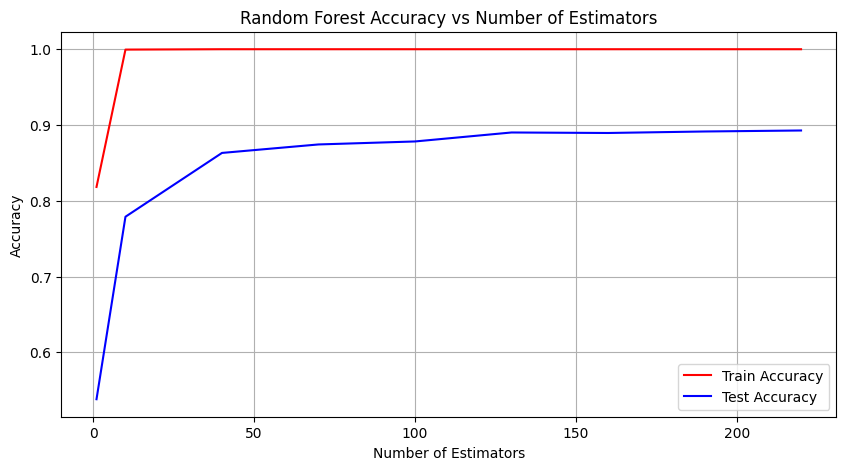

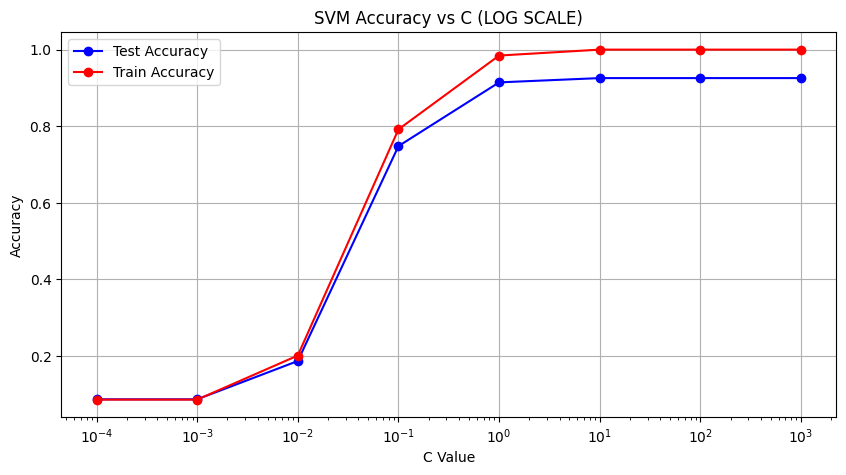

In [4]:
# Random Forest Accuracy vs Number of Estimators
estimators = [1, 10, 40, 70, 100, 130, 160, 190, 220 ]
train_accuracies = []
test_accuracies = []

for n in estimators:# Iterate over different number of estimators defined above

    model1 = RandomForestClassifier(n_estimators=n, random_state=42)# Instantiate the Random Forest Classifier with n estimators and fixed random state
    model1.fit(X_train, y_train)# Train Random Forest model with n estimators
    train_accuracies.append(accuracy_score(y_train, model1.predict(X_train)))# Compute and store train accuracy when estimotr = n
    test_accuracies.append(accuracy_score(y_test, model1.predict(X_test)))# Compute and store test accuracy when estimotr = n

# Plotting the results of Random forest accuracies using different estimators as cost function
plt.figure(figsize=(10, 5))
plt.plot(estimators, train_accuracies, label='Train Accuracy', color='r')
plt.plot(estimators, test_accuracies, label='Test Accuracy',color='b')
plt.xlabel('Number of Estimators')
plt.ylabel('Accuracy')
plt.title('Random Forest Accuracy vs Number of Estimators')
plt.legend()
plt.grid(True)
plt.show()

# SVM Accuracy vs C
C_values = [0.0001,0.001,0.01,0.1,1,10,100,1000]
TESTaccuracies = []
TRAINaccuracies = []


for C in C_values:# Iterate over different C values defined above
    model2 = SVC(C=C) # Instantiate the Support Vector Classifier (SVC) with C = C
    model2.fit(X_train, y_train) # Train the SVM model on the training data
    TESTaccuracies.append(accuracy_score(y_test, model2.predict(X_test))) # Compute and store Test accuracy when C = C
    TRAINaccuracies.append(accuracy_score(y_train, model2.predict(X_train)))# Compute and store train accuracy when C = C

# Plotting the results of SVM accuracies using different estimators as cost function    
plt.figure(figsize=(10, 5))
plt.plot(C_values, TESTaccuracies, marker='o', linestyle='-', color='b', label='Test Accuracy')
plt.plot(C_values, TRAINaccuracies, marker='o', linestyle='-', color='r', label='Train Accuracy')
plt.title('SVM Accuracy vs C (LOG SCALE)')
plt.xlabel('C Value')
plt.ylabel('Accuracy')
plt.xscale('log')  # C is growing exponentially so we using a logarithmic scale for x axis 
plt.legend()
plt.grid(True)
plt.show()

## Cnn implementation as model 3, Model4Numero

In [6]:
# These lists will store the preprocessed images in x and corresponding labals in y
x = []
y = []
#The first loop iterates over each of the 14 folder in the specified directory.
#The second loop iterates over the images within the the folder 
#Represents entire database as image inputs, x and labels of images, y for all images 
for folder in os.listdir(datadir):
    path = os.path.join(datadir, folder)
    for images in os.listdir(path):
        img = cv2.imread(os.path.join(path, images))
        x.append(img)
        y.append(folder)

In [7]:
X = [] # Initialize an empty list to store processed images
for i in range(len(x)): # Iterate over indices of input list x
    img = x[i] # Retrieve image at current index i
    img_gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY) # Convert image to grayscale
    threshold_image = cv2.threshold(img_gray, 0, 255, cv2.THRESH_BINARY_INV|cv2.THRESH_OTSU)[1] # Apply thresholding to obtain binary image using Otsu's method, then select the thresholded image
    threshold_image = cv2.resize(threshold_image, (32, 32))# Resize thresholded image to 32x32 pixels 
    X.append(threshold_image)  # Append resized thresholded image to list X
print(len(X)) # Print the number of processed images

7600


In [8]:
#used to encode categorical labels (classes) into numerical labels
label_encoder = LabelEncoder() # Initialize a LabelEncoder object
y = label_encoder.fit_transform(y) # Apply label encoding to the target variable y
print(len(y)) # Print the length of the transformed y

7600


In [9]:
X_train, X_test, Y_train, Y_test = train_test_split(X, y, test_size=0.2)# #split the dataset into two, 20% for testing, and the remaining 80% for training


In [10]:
#Converts it from normal py arrays/ lists to numpy list for procsiing benefits 
X_train = np.array(X_train) 
X_test = np.array(X_test)
Y_train = np.array(Y_train)
Y_test = np.array(Y_test)

#represents categorical data in a numerical format
Y_train = to_categorical(Y_train)
Y_test = to_categorical(Y_test)


#ensures input data is in expected 3D shape for machine learning CNN model
X_train = np.expand_dims(X_train, axis=-1)
X_test = np.expand_dims(X_test, axis=-1)

# Normalize pixel values to a range between 0 and 1
X_train = X_train/255.
X_test = X_test/255.

In [11]:
def math_symbol_and_digits_recognition(input_shape=(32, 32, 1)):# Defining our function to create a convolutional neural network with the input shape as an argument 
    #regularizer = l2(0.01)## Regularization parameter for L2 regularization if needed
    model3 = Sequential()# Create a Sequential model
    model3.add(Input(shape=input_shape))# Add input layer with specified input shape
    
    # Add first convolutional layer with 32 filters, 3x3 kernel size, 'same' padding, ReLU activation, and no regularization
    model3.add(Conv2D(32, (3, 3), strides=(1, 1), padding='same', 
                     kernel_initializer=glorot_uniform(seed=0), 
                     name='conv1', activity_regularizer=None))
    model3.add(Activation('relu', name='act1'))
    # Add max pooling layer with 2x2 pool size and 2x2 strides, for dimensionality reduction and feature extraction
    model3.add(MaxPool2D((2, 2), strides=(2, 2)))
    
    
    
    # Add second convolutional layer with 32 filters, 3x3 kernel size, 'same' padding, ReLU activation, and no regularization
    model3.add(Conv2D(32, (3, 3), strides=(1, 1), padding='same', 
                     kernel_initializer=glorot_uniform(seed=0), 
                     name='conv2', activity_regularizer=None))
    model3.add(Activation('relu', name='act2'))
    # Add max pooling layer with 2x2 pool size and 2x2 strides, for dimensionality reduction and feature extraction
    model3.add(MaxPool2D((2, 2), strides=(2, 2)))
    
    
    
    # Add third convolutional layer with 64 filters, 3x3 kernel size, 'same' padding, ReLU activation, and no regularization
    model3.add(Conv2D(64, (3, 3), strides=(1, 1), padding='same', 
                     kernel_initializer=glorot_uniform(seed=0), 
                     name='conv3', activity_regularizer=None))
    model3.add(Activation('relu', name='act3'))
    # Add max pooling layer with 2x2 pool size and 2x2 strides, for dimensionality reduction and feature extraction
    model3.add(MaxPool2D((2, 2), strides=(2, 2)))
    
    
    
    model3.add(Flatten())# Flatten the output of the previous layer
    model3.add(Dropout(0.5))# Apply dropout with a dropout rate of 0.5
    model3.add(Dense(120, activation='relu', kernel_initializer=glorot_uniform(seed=0), name='fc1'))# Add fully connected layer with 120 units and ReLU activation
    model3.add(Dense(84, activation='relu', kernel_initializer=glorot_uniform(seed=0), name='fc2'))# Add fully connected layer with 84 units and ReLU activation
    model3.add(Dense(14, activation='softmax', kernel_initializer=glorot_uniform(seed=0), name='fc3'))# Add output layer with 14 units (for 14 classes) and softmax activation
    
    optimizer = Adam() # Define Adam optimizer
    model3.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=['accuracy']) # Compile the model with categorical cross-entropy loss and accuracy metric
    return model3


In [12]:
# Create an instance of the model
model3 = math_symbol_and_digits_recognition(input_shape=(32, 32, 1))
#model3.summary();

In [13]:
def step_decay(epoch): # Define a function for learning rate scheduling using step decay
    initial_learning_rate = 0.001 # Set the initial learning rate
    dropEvery = 10 # Define the frequency of learning rate drops
    factor = 0.5 # Define the factor by which the learning rate will be reduced
    lr = initial_learning_rate * (factor ** np.floor((1 + epoch) / dropEvery)) # Calculate the learning rate based on the current epoch
    return float(lr) # Return the learning rate as a float value

In [14]:
aug = ImageDataGenerator( # Define an ImageDataGenerator for data augmentation
    zoom_range=0.1, # Randomly zoom images by 10%
    width_shift_range=0.05, # Randomly shift images horizontally by 5%
    height_shift_range=0.05  # Randomly shift images vertically by 5%
)

# Assuming X_train, y_train are properly preprocessed for CNN usage (correct shape and one-hot encoding if needed)
hist = model3.fit( # Train the model using data augmentation
    aug.flow(X_train, Y_train, batch_size=128), # Generate batches of augmented data
    epochs=100, # Number of epochs for training
    validation_data=(X_test, Y_test)  
)


Epoch 1/100


C:\Users\siyan\.julia\conda\3\x86_64\lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:120: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


48/48 ━━━━━━━━━━━━━━━━━━━━ 4s 55ms/step - accuracy: 0.2128 - loss: 2.3743 - val_accuracy: 0.5822 - val_loss: 1.3033
Epoch 2/100
48/48 ━━━━━━━━━━━━━━━━━━━━ 3s 50ms/step - accuracy: 0.5812 - loss: 1.3126 - val_accuracy: 0.7980 - val_loss: 0.6521
Epoch 3/100
48/48 ━━━━━━━━━━━━━━━━━━━━ 3s 51ms/step - accuracy: 0.7523 - loss: 0.7880 - val_accuracy: 0.8671 - val_loss: 0.4189
Epoch 4/100
48/48 ━━━━━━━━━━━━━━━━━━━━ 3s 50ms/step - accuracy: 0.8178 - loss: 0.5619 - val_accuracy: 0.9092 - val_loss: 0.2981
Epoch 5/100
48/48 ━━━━━━━━━━━━━━━━━━━━ 3s 49ms/step - accuracy: 0.8603 - loss: 0.4509 - val_accuracy: 0.9309 - val_loss: 0.2338
Epoch 6/100
48/48 ━━━━━━━━━━━━━━━━━━━━ 3s 50ms/step - accuracy: 0.8811 - loss: 0.3573 - val_accuracy: 0.9368 - val_loss: 0.2111
Epoch 7/100
48/48 ━━━━━━━━━━━━━━━━━━━━ 3s 54ms/step - accuracy: 0.9118 - loss: 0.2853 - val_accuracy: 0.9487 - val_loss: 0.1723
Epoch 8/100
48/48 ━━━━━━━━━━━━━━━━━━━━ 3s 53ms/step - accuracy: 0.9242 - loss: 0.2448 - val_accuracy: 0.9507 - val_l

48/48 ━━━━━━━━━━━━━━━━━━━━ 2s 45ms/step - accuracy: 0.9891 - loss: 0.0356 - val_accuracy: 0.9803 - val_loss: 0.0662
Epoch 52/100
48/48 ━━━━━━━━━━━━━━━━━━━━ 3s 47ms/step - accuracy: 0.9814 - loss: 0.0580 - val_accuracy: 0.9789 - val_loss: 0.0631
Epoch 53/100
48/48 ━━━━━━━━━━━━━━━━━━━━ 2s 46ms/step - accuracy: 0.9867 - loss: 0.0391 - val_accuracy: 0.9743 - val_loss: 0.0719
Epoch 54/100
48/48 ━━━━━━━━━━━━━━━━━━━━ 3s 49ms/step - accuracy: 0.9838 - loss: 0.0503 - val_accuracy: 0.9829 - val_loss: 0.0543
Epoch 55/100
48/48 ━━━━━━━━━━━━━━━━━━━━ 3s 49ms/step - accuracy: 0.9833 - loss: 0.0518 - val_accuracy: 0.9796 - val_loss: 0.0610
Epoch 56/100
48/48 ━━━━━━━━━━━━━━━━━━━━ 3s 48ms/step - accuracy: 0.9870 - loss: 0.0363 - val_accuracy: 0.9743 - val_loss: 0.1005
Epoch 57/100
48/48 ━━━━━━━━━━━━━━━━━━━━ 3s 47ms/step - accuracy: 0.9816 - loss: 0.0555 - val_accuracy: 0.9809 - val_loss: 0.0684
Epoch 58/100
48/48 ━━━━━━━━━━━━━━━━━━━━ 2s 46ms/step - accuracy: 0.9870 - loss: 0.0427 - val_accuracy: 0.9849 

In [15]:
# Example for checking the dimensions
print('X_train shape:', X_train.shape)
print('Y_train shape:', Y_train.shape)

# Example for adding a channel dimension if missing in a grayscale image dataset
if len(X_train.shape) == 3:  # only height, width, and number of samples are present
    X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], X_train.shape[2], 1)

# After adjusting, recheck the shapes
print('Adjusted X_train shape:', X_train.shape)


X_train shape: (6080, 32, 32, 1)
Y_train shape: (6080, 14)
Adjusted X_train shape: (6080, 32, 32, 1)


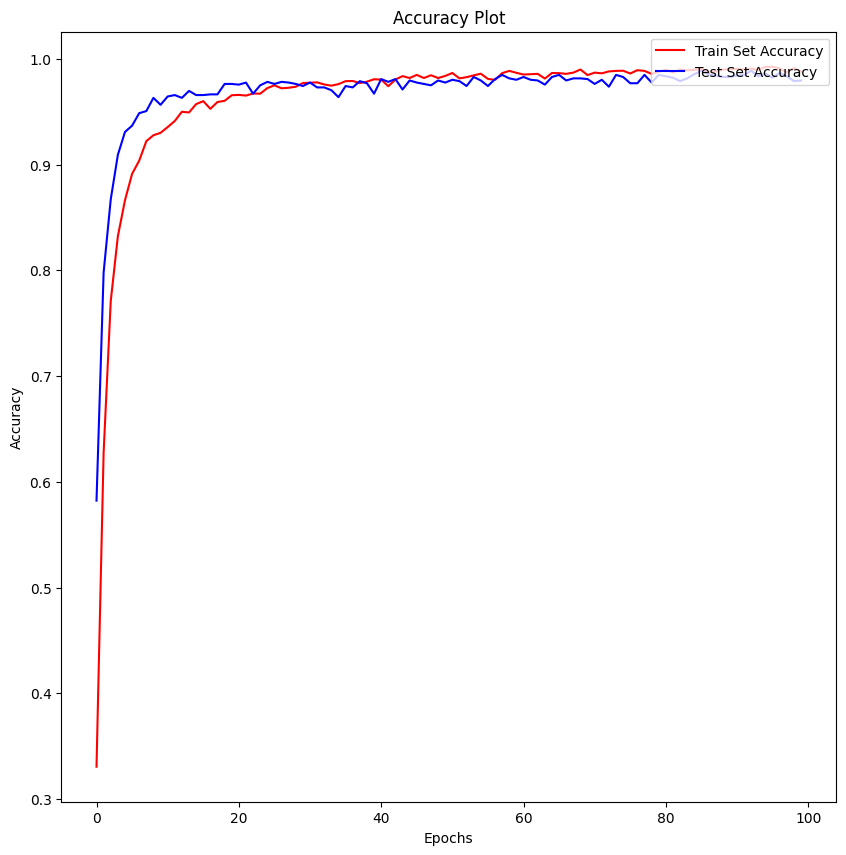

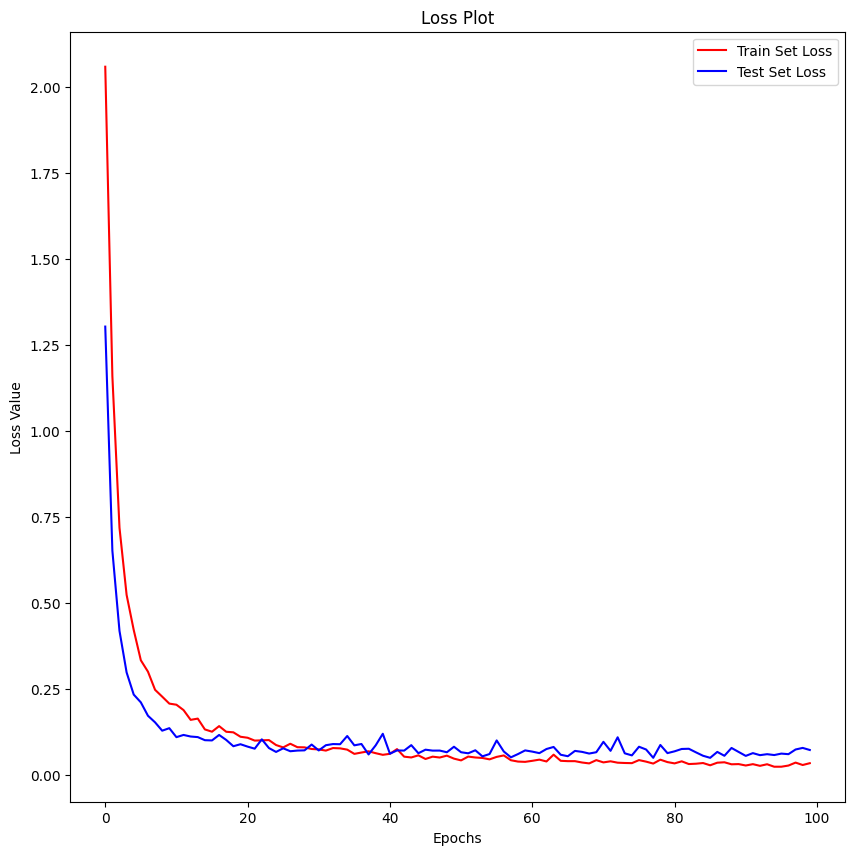

In [16]:
#Accuracy plot of CNN
figure = plt.figure(figsize=(10, 10))
plt.plot(hist.history['accuracy'], label='Train Set Accuracy', color='r')
plt.plot(hist.history['val_accuracy'], label='Test Set Accuracy', color='b')
plt.title('Accuracy Plot')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(loc='upper right')
plt.show()

#Loss plot of CNN
figure2 = plt.figure(figsize=(10, 10))
plt.plot(hist.history['loss'], label='Train Set Loss', color='r')
plt.plot(hist.history['val_loss'], label='Test Set Loss', color='b')
plt.title('Loss Plot')
plt.xlabel('Epochs')
plt.ylabel('Loss Value')
plt.legend(loc='upper right')
plt.show()

In [17]:
ypred = model3.predict(X_test) # Predict labels for the test data using the CNN model
ypred = np.argmax(ypred, axis=1) # Convert predicted probabilities to class labels by selecting the index of the highest probability
Y_test_hat = np.argmax(Y_test, axis=1)# Convert one-hot encoded true labels back to categorical labels

accuracy_cnn = accuracy_score(Y_test_hat, ypred)# Calculate accuracy of the CNN model

print(f'CNN Accuracy: {accuracy_cnn:.2f}') # Print the accuracy of the CNN model
print()
print(classification_report(Y_test_hat, ypred))# Print classification report providing evaluation, not necessary becaue we havent learnt these in clss, but it gives  metrics like precision, recall, and F1-score

48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
CNN Accuracy: 0.98

              precision    recall  f1-score   support

           0       1.00      0.96      0.98       120
           1       0.98      0.97      0.98       117
           2       0.99      1.00      0.99        69
           3       0.96      0.99      0.97       108
           4       0.96      0.95      0.96       111
           5       1.00      0.97      0.98        89
           6       0.97      0.99      0.98       125
           7       0.97      0.97      0.97       111
           8       0.96      0.97      0.96        97
           9       0.96      0.98      0.97       113
          10       1.00      0.96      0.98       140
          11       1.00      1.00      1.00        91
          12       0.98      1.00      0.99        96
          13       0.99      1.00      1.00       133

    accuracy                           0.98      1520
   macro avg       0.98      0.98      0.98      1520
weighted avg       0.

## CNN TESTING - MODEL4NUMERO TEST

In [18]:
import cv2
import numpy as np
import imutils
import matplotlib.pyplot as plt

def numberSymbolClassifier(image_path):# Defining a function to process an image
    def read_and_preprocess(path):#preprocess converts image to standard size and to greyscale
        img = cv2.imread(path) # Read the image
        resized = cv2.resize(img, (800, 800)) # Resize the image
        return cv2.cvtColor(resized, cv2.COLOR_BGR2GRAY) # Convert the resized image to grayscale

    def detect_edges(gray_image):#detects edges in the grayscale image
        return cv2.Canny(gray_image, 30, 150)# Uses Canny edge detection algorithm

    def find_and_sort_contours(edged_image):#finds and sorts contours in the edged image
        contours_info = cv2.findContours(edged_image.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)# Find contours
        contours = imutils.grab_contours(contours_info) # Extract contours
        return sorted(contours, key=cv2.contourArea, reverse=True) # Sort contours by area in descending order

    def preprocess_contour(contour, gray_image):#preprocess a srted contours from the grayscale image
        x, y, w, h = cv2.boundingRect(contour)  # Get bounding rectangle coordinates
        roi = gray_image[y:y+h, x:x+w] # Extract region of interest (ROI)
        thresh = cv2.threshold(roi, 0, 255, cv2.THRESH_BINARY_INV | cv2.THRESH_OTSU)[1] # Apply thresholding
        return thresh # Return preprocessed contour

    def resize_and_normalize(thresh): #resizes and normalizes the preprocessed contour
        padded = cv2.copyMakeBorder(thresh, top=10, bottom=10, left=10, right=10, borderType=cv2.BORDER_CONSTANT, value=(0,0,0)) # Add padding
        resized = cv2.resize(padded, (32, 32))# Resize the contour
        normalized = resized / 255.0 # Normalize pixel values
        return np.expand_dims(normalized, axis=-1) # Expand dimensions to match model input shape

    #Preprocess math expression to grey scale and 800 x 800 pixels 
    img_gray = read_and_preprocess(image_path)
    
    
    #Symbol segmentation of expression
    edged = detect_edges(img_gray) 
    contours = find_and_sort_contours(edged)
    
    # Defing labels for classification
    labels = ['0', '1', '2', '3', '4', '5', '6', '7', '8', '9', 'add', 'div', 'mul', 'sub']

    for contour in contours:# Iterate over each symbol in expression
        # Preprocess the symbol, resize & greyscale 
        thresh = preprocess_contour(contour, img_gray)
        processed_image = resize_and_normalize(thresh)
        
        # Predict label for symbol, symbol classification 
        pred = model3.predict(np.expand_dims(processed_image, axis=0))
        label_index = np.argmax(pred, axis=1)
        label = labels[label_index[0]]
        
        # Get bounding rectangle coordinates for the contour
        x, y, w, h = cv2.boundingRect(contour)
        cv2.rectangle(img_gray, (x, y), (x+w, y+h), (0, 0, 255), 2)# Draw bounding rectangle around the symbol
        cv2.putText(img_gray, label, (x-5, y), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 0, 255)) # Display predicted label near the symbol

    # Display the processed image with bounding boxes and predicted labels    
    plt.figure(figsize=(10, 10))
    plt.imshow(cv2.cvtColor(img_gray, cv2.COLOR_GRAY2RGB))
    plt.axis('off')
    plt.show()


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


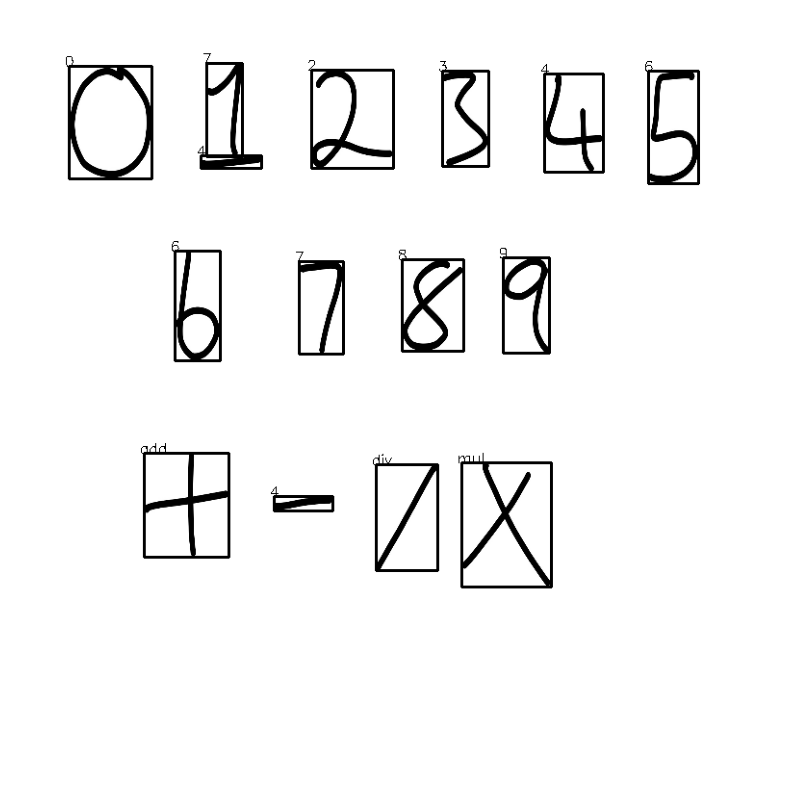

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


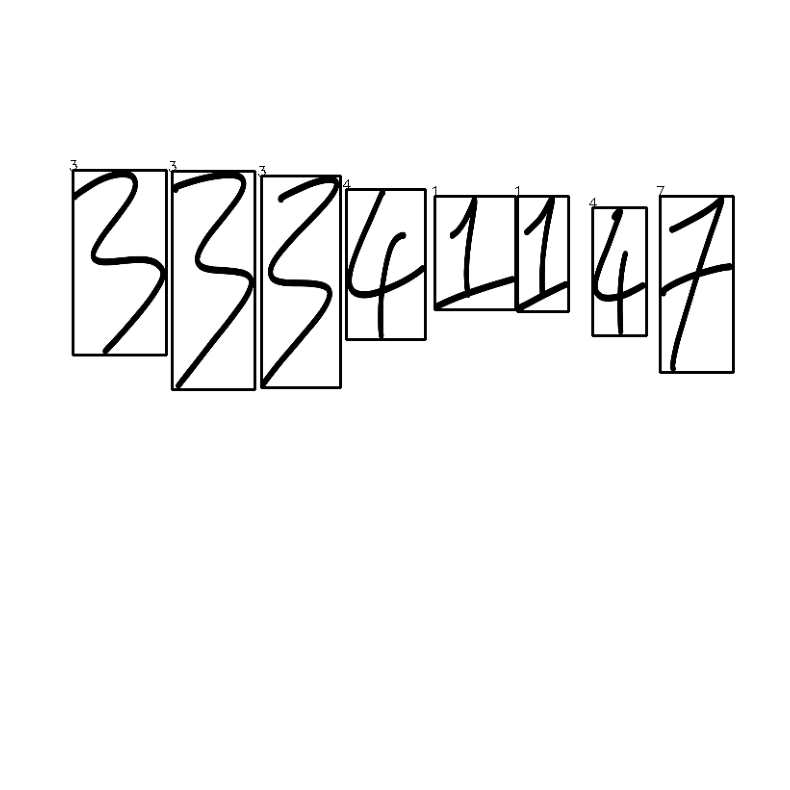

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step


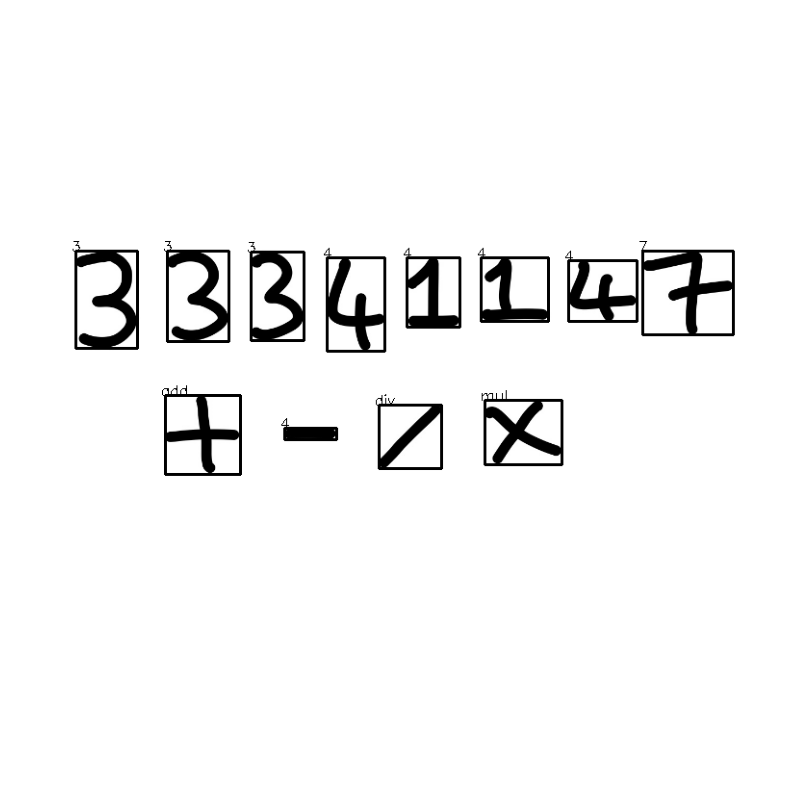

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


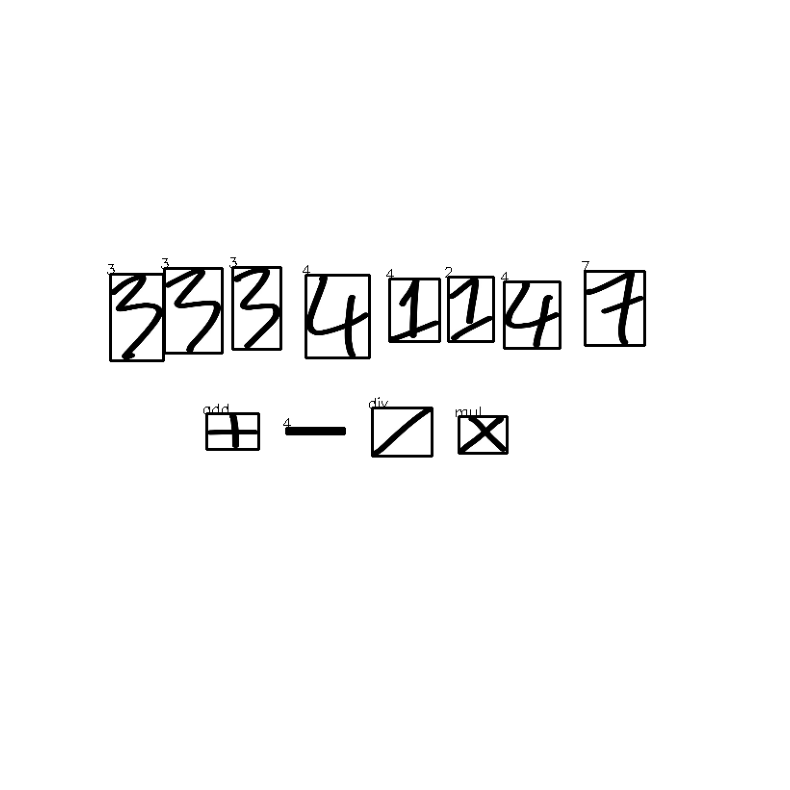

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


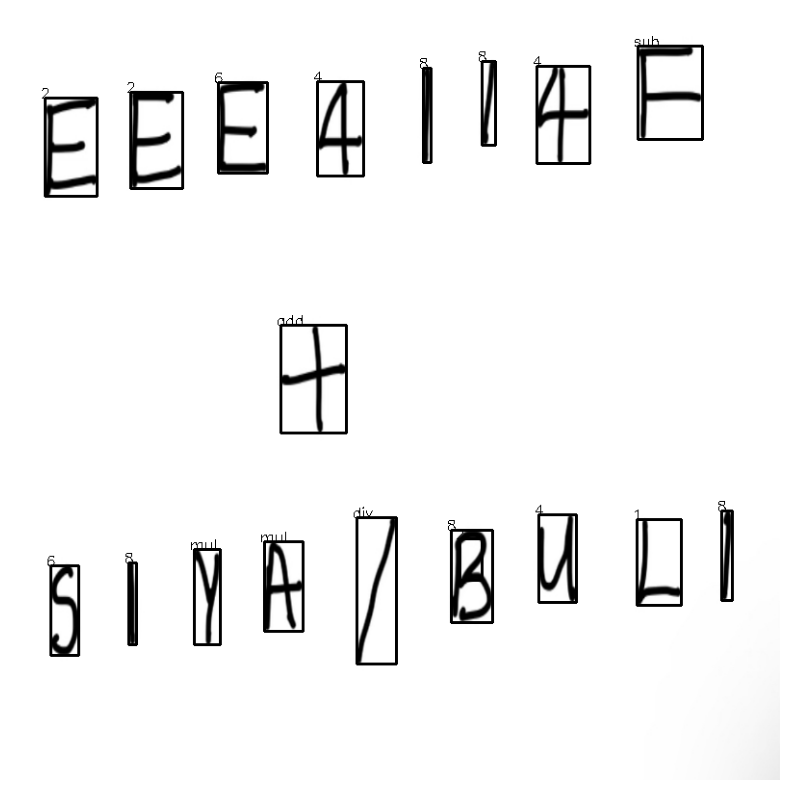

In [19]:
numberSymbolClassifier('data/test1.jpeg')
numberSymbolClassifier('data/test2.jpeg')
numberSymbolClassifier('data/test3.jpeg')
numberSymbolClassifier('data/test4.jpeg')
numberSymbolClassifier('data/test5.jpg')